# (31) Smoothen CA2

**Motivation**: Smoothen Ca data (raw), save. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, Latex

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
# from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def apply_gaussian(
    raw: np.ndarray,
    sigmas: List[float],
    truncate: float = 4.0):
    data, ab, bad_t = remove_badt_ca(
        data=flatten_arr(raw),
        run_duration=mice.cfg.run_duration,
        exclude=mice.cfg.exclude,
        fs=mice.cfg.fs_ca,
    )
    data = data.reshape((*raw.shape[:2], -1))
    data = sp_stats.zscore(data, axis=-1)
    data = np.nan_to_num(data, nan=0.0)

    if not isinstance(sigmas, Iterable):
        sigmas = [sigmas]
    y = {
        sig: np.zeros(data.shape)
        for sig in sigmas
    }
    for sig in sigmas:
        for t in range(data.shape[-1]):
            y[sig][..., t] = sp_img.gaussian_filter(
                input=data[..., t],
                sigma=sig,
                truncate=truncate,
            )

    t = mice.cfg.run_duration * mice.cfg.fs_ca
    final = {
        sig: np.zeros((*data.shape[:-1], t))
        for sig in sigmas
    }

    good_t = np.zeros(t).astype(bool)
    good_t[ab] = True
    good_t[ab][bad_t] = False
    for sig in sigmas:
        final[sig][..., good_t] = y[sig]
    return final

## Prep

In [3]:
from register.register import reset_ants_img
from register.preprocess import remove_badt_ca

In [4]:
mice = Mice(512, full_load=True)
print(mice.kws)

{
    'task': 'rest',
    'exclude': True,
    'runs_only': True,
    'band_ca2': (0.01, 5.0),
    'band_bold': (0.01, 0.5),
    'desc_ca2': 'preproc',
    'desc_bold': 'rabies-hp'
}

## Save smoothened CA2

In [5]:
from register.register import Register, default_descs
from model.mouse import _EXCLUDE_CA

len(_EXCLUDE_CA), len(mice.ca_preproc)

(5, 210)

In [6]:
sigmas = [32, 48]
pbar = tqdm(mice.ca_preproc.items())

for k, f in pbar:
    # skip LED runs, etc
    cond_skip = (
        f.task != 'rest' or
        f.nii_file is None or
        mice.looper[k] in _EXCLUDE_CA
    )
    if cond_skip:
        continue
    # if exists, continue
    file = f'sig{sigmas[0]:0.0f}'
    file = f.nii_file.replace('preproc', file)
    file = pjoin(mice.cfg.raw_dir, file)
    if os.path.isfile(file):
        continue
    pbar.set_description(k)

    # load raw data
    img = f.load_ants()
    raw = img.numpy()[..., 0, :]
    mask = np.mean(np.abs(raw), -1) > 0
    raw[~mask] = np.nan
    
    # apply smoothing kernel
    final = apply_gaussian(raw, sigmas)
    
    # save results
    for sig, x in final.items():
        final_img = reset_ants_img(
            img=np.expand_dims(x, -2),
            spacing=img.spacing,
            origin=img.origin,
            dtype=img.dtype,
            use_um=False,
        )
        file = f'sig{sig:0.0f}'
        file = f.nii_file.replace('preproc', file)
        file = pjoin(mice.cfg.raw_dir, file)
        ants.image_write(final_img, file)

sub-SLC10_ses-3_run-7: 100%|██████████| 210/210 [16:25:42<00:00, 281.63s/it]  


## Do the registration

Use ```mice.node_lookup``` as the ```accepted``` variable.

In [7]:
%%time

mode = 'ca2'
reg = Register(mice)
reg.set_mode(mode)

logger = make_logger(
    name='organize_ca2_sigma',
    path=mice.cfg.log_dir,
    verbose=reg.verbose,
    module=__name__,
)
for sig in sigmas:
    desc = f'sig{sig:0.0f}'
    kws = {f"desc_{mode}": desc}
    reg.mice.setup_preproc_data(**kws)
    reg._organize_func(
        tsnr_masks=reg.get_tsnr_masks()[mode],
        accepted_regions=list(mice.node_lookup[mode].values()),
        description=desc,
        logger=logger,
    )

logger 'organize_ca2_sigma_(2023_09_03).log' created at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-512*3/log

Name: brain . . . a total of: 6017 regions accepted, 265 regions rejected.
accept ratio: 95.78 %, reject ratio: 4.22 %, using a presence threshold of 20.0 %

Organizing sub-SLC10_ses-3_run-7 (ca2 / sig32): 100%|██████████| 210/210 [35:15<00:00, 10.08s/it]


Name: brain . . . a total of: 6017 regions accepted, 265 regions rejected.
accept ratio: 95.78 %, reject ratio: 4.22 %, using a presence threshold of 20.0 %

Organizing sub-SLC10_ses-3_run-7 (ca2 / sig48): 100%|██████████| 210/210 [34:40<00:00,  9.90s/it]

CPU times: user 59min 24s, sys: 17min 58s, total: 1h 17min 22s
Wall time: 1h 11min 17s


In [8]:
reg.mode

'ca2'

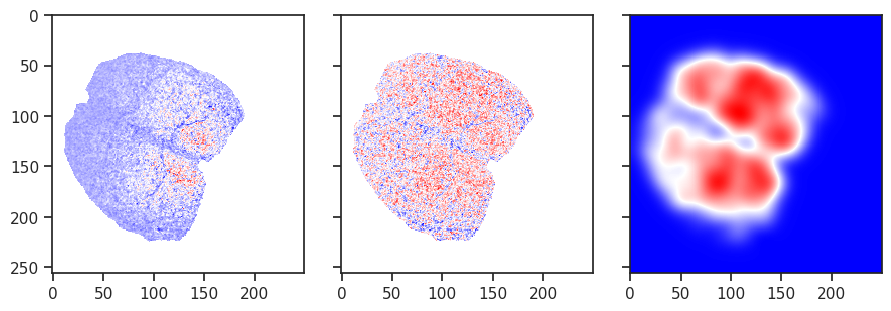

In [7]:
t = 1600

fig, axes = create_figure(1, 3, (9, 3), 'all', 'all', 'constrained')
axes[0].imshow(raw[..., t], cmap='bwr')
axes[1].imshow(sp_stats.zscore(raw, axis=-1)[..., t], cmap='bwr')
axes[2].imshow(final[..., t], cmap='bwr')
plt.show()

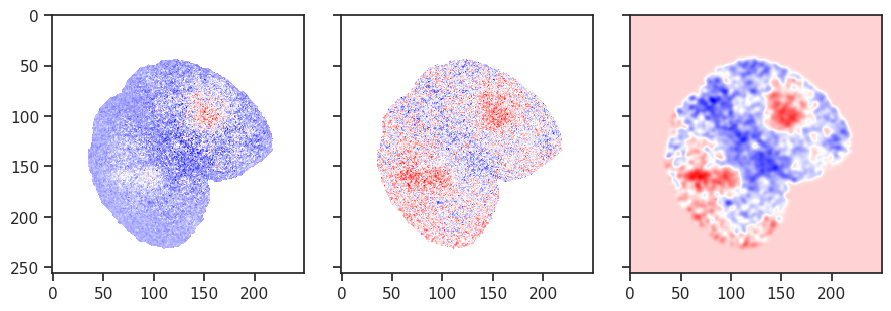

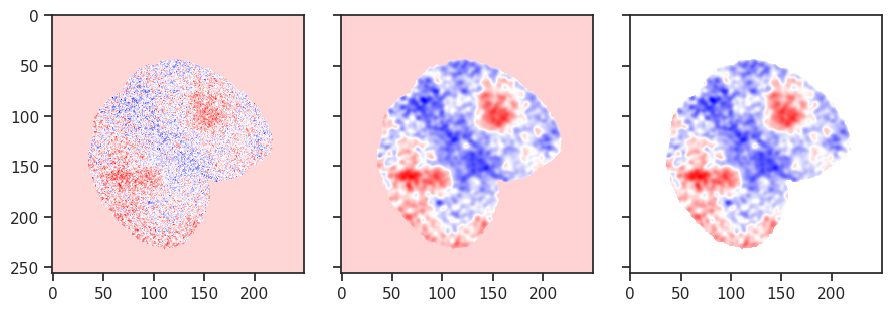

In [8]:
sigma = 2.0
sigma * 6 * 50 / 1000

0.6

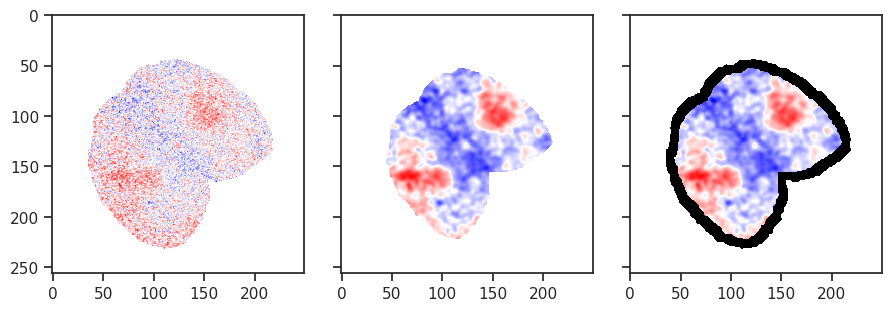

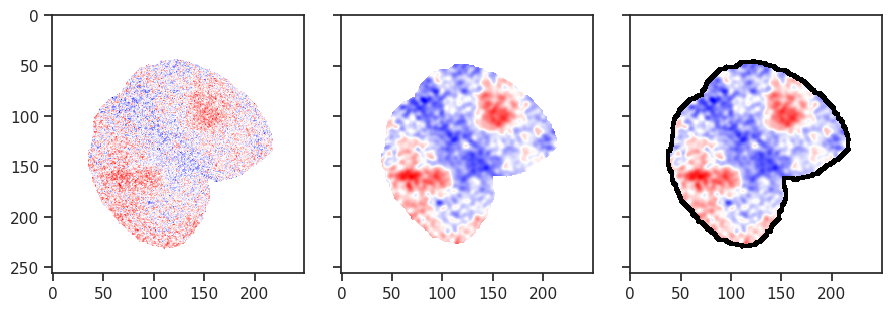

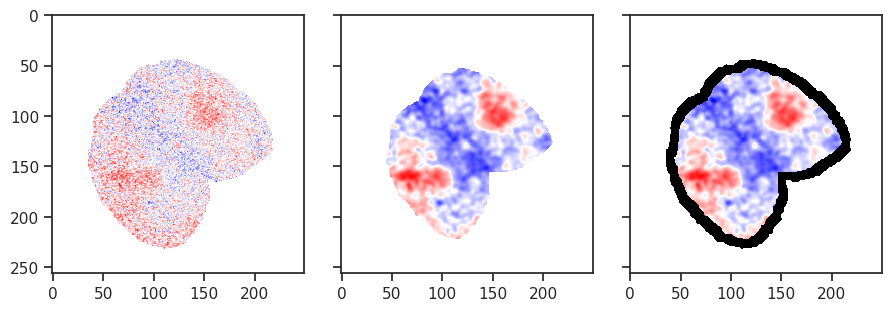

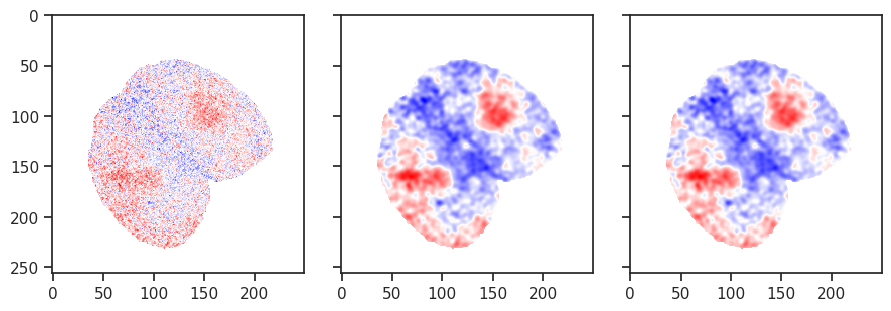

In [69]:
y = sp_img.gaussian_filter(raw_zs[..., 1600], sigma=4)

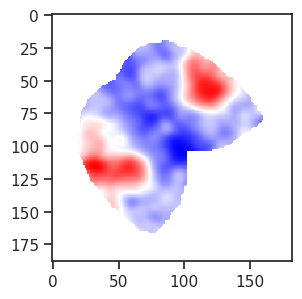

In [70]:
plt.imshow(y, cmap='bwr');

In [101]:
sigma = 3.0
truncate = 4.0

u = raw_zs[..., 1600].copy()

v = u.copy()
v[np.isnan(u)] = 0
vv = sp_img.gaussian_filter(v, sigma, truncate=truncate)

w = 0 * u.copy() + 1
w[np.isnan(u)] = 0
ww = sp_img.gaussian_filter(w, sigma, truncate=truncate)

z = vv / ww

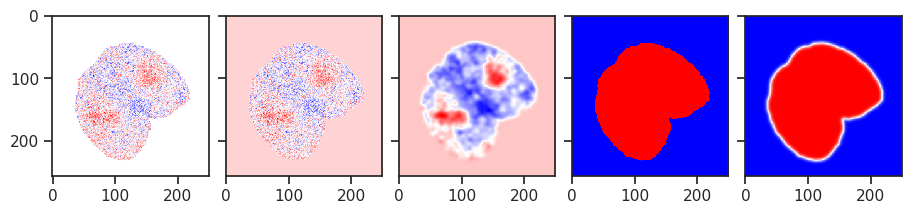

In [102]:
fig, axes = create_figure(1, 5, (9, 2.), 'all', 'all', 'constrained')
axes[0].imshow(u, cmap='bwr')
axes[1].imshow(v, cmap='bwr')
axes[2].imshow(vv, cmap='bwr')
axes[3].imshow(w, cmap='bwr')
axes[4].imshow(ww, cmap='bwr')
plt.show()

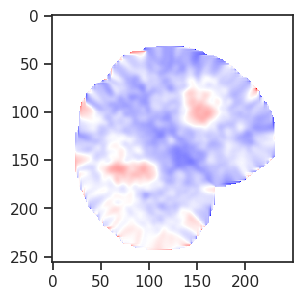

In [103]:
plt.imshow(z, cmap='bwr');